## Predicting Bike Rental Station Traffic

#### TODO:
- make start/end models for each of the 6 groups
- make function: input date/region, get traffic pred / actual
- repo writeup (requirements/put authorship in py/slice of data)
- flask basic
- flask interactive

#### future:
- include weather for multi https://www.ncdc.noaa.gov/cdo-web/datatools/lcd
- live feed: https://gbfs.divvybikes.com/gbfs/gbfs.json

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

plt.style.use('ggplot')

In [2]:
def basic_dist(row):
    # Gives a basic euclidean trip distance in m
    
    if row['round_trip'] == 1:
        return 0
    
    a = (row['start_lat'], row['start_lng'])
    
    b = (row['end_lat'], row['end_lng'])
    
    return geodesic(a, b).km * 1000

In [3]:
def station_data(region, eda=False, start_end=None):
    '''Loads, preps, and filters data for machine learning or EDA'''
    
    # grab a set of station names for a given region
    stations = get_stations(region)
    
    # Gather one years worth of data
    filelist = []
    frames = []
    
    for month in [4,5,6,7,8,9,10,11,12]:
        filelist.append('data/2020{:02d}-divvy-tripdata.csv'.format(month))
    for month in [1,2,3]:
        filelist.append('data/2021{:02d}-divvy-tripdata.csv'.format(month))
    
    usecols = ['started_at', 'ended_at', 'start_station_name', 'end_station_name', 'member_casual', 
               'rideable_type', 'start_lat', 'start_lng', 'end_lat', 'end_lng']

    # actually grab the data
    for month in filelist:
        lil_df = pd.read_csv(month, usecols=usecols)
            
        # decide weather to look at trips starting and/or ending in our selected region
        if start_end == 'end':
            mask = (lil_df['end_station_name'].isin(stations))
        if start_end == 'start':
            mask = (lil_df['start_station_name'].isin(stations))
        else:
            mask1 = (lil_df['end_station_name'].isin(stations))
            mask2 = (lil_df['start_station_name'].isin(stations))
            mask = mask1 | mask2
    
        lil_df = lil_df[mask]
        
        frames.append(lil_df)

    df = pd.concat(frames, ignore_index=True)
    
    # Only relevant missing data is lat/long, warns us if ever dropping more than 1%
    allrows = df.shape[0]
    
    df = df[df['start_lat'].notna()]
    df = df[df['end_lat'].notna()]
    if allrows/df.shape[0] > 1.01:
        print('DROP WARNING: more than 1% of rows null')

    df = df.reset_index(drop=True)

    # prepping for machine learning
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['started_at'] = pd.to_datetime(df['started_at'])

    df['date'] = pd.to_datetime(df['ended_at']).dt.date
    df['hour'] = df['ended_at'].dt.hour
    
    # For some reason each month has a few extra trips from the upcoming month
    # change this date if you want to use newer data
    df = df[df['date'] < pd.to_datetime('2021-04-01')]

    # Future implementation can include weather data
    #weather = grab_weather()
    #df = df.merge(weather, how='left', left_on=['date', 'hour'], right_on=['date', 'hour'])
    
    # AI wouldn't have following aggregate features available for predictions, so they aren't included
    if eda == False:      
        # prep for machine learning
        
        return vectorize(df)

    # daylight savings makes a few negative trip times, a quick approximate fix is okay
    df['trip_time'] = abs((df['ended_at'] - df['started_at']).dt.total_seconds())
    
    # All trips above 10,800 seconds (3 hrs) are on Nov 25, must be some systemic thing
    df = df[df['trip_time'] < 10800]

    df['round_trip'] = df.apply(lambda x: 1 if x['start_station_name'] == x['end_station_name'] else 0, axis=1)

    df['electric'] = df['rideable_type'].apply(lambda x: 1 if x == 'electric_bike' else 0)

    df['member'] = df['member_casual'].apply(lambda x: 1 if x == 'member' else 0)

    df['trip_dist'] = df.apply(basic_dist, axis=1)
    
    dropcols = ['rideable_type', 'member_casual', 'started_at', 'ended_at', 'start_lat', 'start_lng',
                'end_lat', 'end_lng', 'start_station_name',  'end_station_name']
    
    df = df.drop(columns=dropcols)
    
    # extract target and add to output
    out = df.groupby(['date', 'hour']).agg('mean')
    
    out['target'] = df.groupby(['date', 'hour']).size()
    
    # Some hours are missing, we want to include a row for that hour with target = 0
    dti = pd.Series(pd.date_range("2020-04-01", freq="D", periods=365)).dt.date

    idx = pd.MultiIndex.from_product([dti, np.arange(24)], names=['date', 'hour'])

    # TODO: add weather columns below
    df_blank = pd.DataFrame(data = np.zeros(shape=(365*24, 6)), 
                            index = idx,
                            columns = ['trip_time', 'round_trip', 'electric', 'member',
                                       'trip_dist', 'target'])

    out = pd.concat([df_blank, out]).groupby(['date', 'hour']).agg('sum')
    
    out = out.reset_index(drop=True)

    return out

In [4]:
def grab_weather():
    '''Loads and preps weather data in a pandas df'''
    
    #weather = pd.read_csv()
    
    #process it
    
    pass

In [5]:
def get_stations(region):
    '''Returns the set of station names necessary for grouping data
    
    possible regions: 'downtown', 'lincoln_park', 'wicker_park', 'hyde_park', 'uptown', 'chinatown'   
    '''

    groups = pd.read_csv('models/station_groups.csv')

    return set(groups[groups['group'] == region].name.values)

In [6]:
def vectorize(inputdf):
    '''Takes eda ready data and preprocesses it for machine learning'''
       
    # extract target and add to output
    out = inputdf.groupby(['date', 'hour']).agg('mean')
    
    out['target'] = inputdf.groupby(['date', 'hour']).size()
    
    dropcols = ['start_lat', 'start_lng', 'end_lat', 'end_lng']

    out = out.drop(columns=dropcols)
    
    # Some hours are missing, we want to include a row for that hour with target = 0
    dti = pd.Series(pd.date_range("2020-04-01", freq="D", periods=365)).dt.date

    idx = pd.MultiIndex.from_product([dti, np.arange(24)], names=['date', 'hour'])

    # change feature names / amount when you have them
    df_blank = pd.DataFrame(data = np.zeros(shape=(365*24, 1)), index=idx,
                            columns=['target'])

    out = pd.concat([df_blank, out]).groupby(['date', 'hour']).agg('sum')
    
    out = out.reset_index(drop=True)
    
    return out
    
    # weather data would need to be scaled    
#     y = np.array(out.iloc[:, -1])
    
#     scaler = MinMaxScaler()
    
#     out = scaler.fit_transform(out.iloc[:, :-1])
    
#     return np.append(out, y.reshape(-1, 1), axis=1), scaler

## EDA

In [159]:
dt_s = station_data('downtown', start_end='start')
dt_e = station_data('downtown', start_end='end')

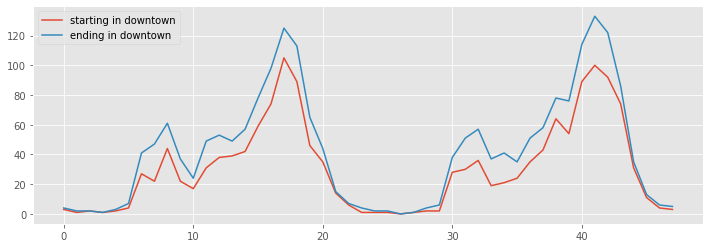

In [172]:
# figure of trips ending in downtown and starting in downtown (trips within downtown included in both)
# notice how there are consistently more trips coming into downtown
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(48), dt_s[:48], label='starting in downtown')
ax.plot(np.arange(48), dt_e[:48], label='ending in downtown')
ax.legend();

In [185]:
dt_s.shape

(8760, 1)

In [177]:
# not once, not one time in 8760 hours did more bikes come into downtown than left downtown
dt_d = dt_e - dt_s

dt_d[dt_d['target'] < 0]

,target


In [180]:
dt_eda = station_data('downtown', eda=True)

dt_eda

,trip_time,round_trip,electric,member,trip_dist,target
0,441.750000,0.000000,0.000000,1.000000,1524.837027,4.0
1,428.500000,0.000000,0.000000,1.000000,1424.681233,2.0
2,1337.500000,0.500000,0.000000,0.500000,1907.174361,2.0
3,1027.000000,0.000000,0.000000,1.000000,4271.683931,1.0
4,495.666667,0.000000,0.000000,1.000000,1778.573884,3.0
...,...,...,...,...,...,...
8755,817.084848,0.048485,0.260606,0.800000,1823.531286,165.0
8756,1016.803738,0.028037,0.289720,0.738318,1903.862947,107.0
8757,1217.700000,0.012500,0.412500,0.787500,2051.440106,80.0
8758,764.440000,0.020000,0.340000,0.700000,1766.075320,50.0


In [181]:
dt_eda_e = station_data('downtown', eda=True, start_end='end')
dt_eda_s = station_data('downtown', eda=True, start_end='start')

In [182]:
dt_eda_s

,trip_time,round_trip,electric,member,trip_dist,target
0,362.666667,0.000000,0.000000,1.000000,1216.697230,3.0
1,513.000000,0.000000,0.000000,1.000000,2094.080661,1.0
2,1337.500000,0.500000,0.000000,0.500000,1907.174361,2.0
3,1027.000000,0.000000,0.000000,1.000000,4271.683931,1.0
4,572.000000,0.000000,0.000000,1.000000,2184.351421,2.0
...,...,...,...,...,...,...
8755,813.171429,0.057143,0.250000,0.800000,1728.302361,140.0
8756,1093.385542,0.036145,0.253012,0.722892,1962.004095,83.0
8757,1460.100000,0.020000,0.380000,0.760000,2085.595707,50.0
8758,792.842105,0.026316,0.263158,0.710526,1739.357000,38.0


In [183]:
# notably there are 262 missing rows, meaning that many hours had no traffic
dt_eda[dt_eda['target'] < 1]

,trip_time,round_trip,electric,member,trip_dist,target
26,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0
122,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
8041,0.0,0.0,0.0,0.0,0.0,0.0
8042,0.0,0.0,0.0,0.0,0.0,0.0
8187,0.0,0.0,0.0,0.0,0.0,0.0
8330,0.0,0.0,0.0,0.0,0.0,0.0


## groups
loosely based off this map: https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations-All-Map/bk89-9dk7

In [152]:
# Downtown
group_a = set([92,146,47,217,285,31,119,191,286,21,53,125,32,173,96,6,181,
           39,77,33,7,196,86,81,638,110,24,627,107,109,277,212,198,
           264,45,2,89,84,75,98,211,337,164,37,161,25,672,195,43,636,
           36,142,197,350,175,169,26,35,111,66,215,192,635,56,18,74,
           122,100,233,76,624,199,631,5,73,174,80,38,186,383,106,194,
           40,621,52,48,99,346,51,91,284,68,88,49,134,90,44,54,71,112,
           283,623,287,133,50,637,654])

len(group_a)

107

In [153]:
# Lincoln park
group_b = set([127,163,327,131,188,349,288,177,223,162,157,319,67,87,143,
           154,226,220,302,153,505,141,34,58,115,310,228,300,332,219,
           258,144,329,250,94,166,340,307,156,324,296,334,13,504,313,
           309,225,673,190,152,117,113,343,664])

len(group_b)

54

In [154]:
# Wicker park
group_c = set([666,92,69,158,224,365,511,506,86,276,183,213,216,510,305,
           622,128,58,331,130,659,20,315,61,219,17,509,16,508,350,93,
           657,30,374,29,159,160,210,628,60,373,116,333,54,641,637,643,
           658])

len(group_c)

48

In [155]:
# Hyde park
group_d = set([12,564,567,121,431,561,426,101,418,345,559,11,565,569,398,
           568,388,652,328,393,248,560,572,428,562,385,102,95,355,653,
           427,392,395,415,247,555,386,400,421,422,556,399,351,423,
           420,575,557,424,593,570,391,647,356,396,384,430,352,571,554,
           563,390,425,429,270,322,558,417,204,419,649,650,674,646,648,
           678,679])

len(group_d)

76

In [156]:
# Uptown
group_e = set([245,481,478,234,240,312,292,475,311,463,238,465,471,316,
           231,472,326,486,243,297,253,246,314,298,249,306,323,295,
           318,239,325,242,251,244,256,476,477,639,254,480,293,464,
           482,344])

len(group_e)

44

In [157]:
# Chinatown
group_f = set([402,62,403,272,132,280,401,120,339,406,207,171,370,148,147,
           237,193,4,135,184,206,42,366,209,335,150,208,368,263,149])

len(group_f)

30

In [142]:
# raw data for whatever you might need it for
filelist = []
frames = []

for month in [4,5,6,7,8,9,10,11,12]:
    filelist.append('data/2020{:02d}-divvy-tripdata.csv'.format(month))
for month in [1,2,3]:
    filelist.append('data/2021{:02d}-divvy-tripdata.csv'.format(month))

for month in filelist:
    lil_df = pd.read_csv(month)

    frames.append(lil_df)

dfraw = pd.concat(frames, ignore_index=True)

dfraw

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86,Lincoln Ave & Diversey Pkwy,152.0,41.896400,-87.661000,41.932200,-87.658600,member
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503,Kosciuszko Park,499.0,41.924400,-87.715400,41.930600,-87.723800,member
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142,Indiana Ave & Roosevelt Rd,255.0,41.894500,-87.617900,41.867900,-87.623000,member
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216,Wood St & Augusta Blvd,657.0,41.903000,-87.697500,41.899200,-87.672200,member
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125,Sheridan Rd & Lawrence Ave,323.0,41.890200,-87.626200,41.969500,-87.654700,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489743,9397BDD14798A1BA,docked_bike,2021-03-20 14:58:56,2021-03-20 17:22:47,Michigan Ave & Oak St,13042,New St & Illinois St,TA1306000013,41.900960,-87.623777,41.890847,-87.618617,casual
3489744,BBBEB8D51AAD40DA,classic_bike,2021-03-02 11:35:10,2021-03-02 11:43:37,Kingsbury St & Kinzie St,KA1503000043,New St & Illinois St,TA1306000013,41.889177,-87.638506,41.890847,-87.618617,member
3489745,637FF754DA0BD9E1,classic_bike,2021-03-09 11:07:36,2021-03-09 11:49:11,Michigan Ave & Oak St,13042,Clark St & Berwyn Ave,KA1504000146,41.900960,-87.623777,41.977997,-87.668047,member
3489746,F8F43A0B978A7A35,classic_bike,2021-03-01 18:11:57,2021-03-01 18:18:37,Kingsbury St & Kinzie St,KA1503000043,New St & Illinois St,TA1306000013,41.889177,-87.638506,41.890847,-87.618617,member


In [167]:
group_f2 = []

for stationid in group_f:

    name = dfraw[dfraw['end_station_id'] == stationid]
    
    if len(name) == 0:
        print('no ', stationid)
    else:
        group_f2.append(name.iloc[0]['end_station_name'])

    df_f = pd.DataFrame(group_f2, columns=['name'])

    df_f['group'] = 'f'

df_f

,name,group
0,Wentworth Ave & 24th St (Temp),f
1,Burnham Harbor,f
2,Halsted St & 21st St,f
3,Rhodes Ave & 32nd St,f
4,Indiana Ave & 31st St,f
5,Shields Ave & 28th Pl,f
6,Shields Ave & 31st St,f
7,Wentworth Ave & 33rd St,f
8,State St & 33rd St,f
9,Indiana Ave & 26th St,f


In [168]:
groups = pd.concat([df_a, df_b, df_c, df_d, df_e, df_f])

## post-processing eda

In [7]:
def serialize(inputdf, scale=True):
    '''Takes eda ready data and preprocesses it for machine learning'''
    
    out = inputdf.groupby(['date', 'hour']).agg('mean')
    
    out['size'] = inputdf.groupby(['date', 'hour']).size()
    
    dti = pd.Series(pd.date_range("2020-04-01", freq="D", periods=365)).dt.date

    idx = pd.MultiIndex.from_product([dti, np.arange(24)], names=['date', 'hour'])

    # change feature names / amount
    df_blank = pd.DataFrame(data = np.zeros(shape=(365*24, 6)), index=idx,
                            columns=['trip_time', 'round_trip', 'electric', 'member',
                                     'trip_dist', 'size'])

    out = pd.concat([df_blank, out]).groupby(['date', 'hour']).agg('sum')
    
    out = out.reset_index(drop=True)
    
    return out

In [8]:
def windowize_data(data, n_prev, univariate=True):
    '''univariate'''
    n_predictions = len(data) - n_prev
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    
    if univariate == False:
        y = data[n_prev:, -1]
        x = data[indices]
    else:
        y = data[n_prev:]
        x = data[indices, None]
    return x, y

In [9]:
def split_and_windowize(data, n_prev, fraction_test=0.1, univariate=True):
    '''Train/test splits data with added timestep dimension'''
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev, univariate=univariate)
    x_test, y_test = windowize_data(data[n_train:], n_prev, univariate=univariate)
    return x_train, x_test, y_train, y_test

In [ ]:
downtown_start = station_data('downtown', eda=False, start_end='start')

In [240]:
X_train, X_test, y_train, y_test = split_and_windowize(np.array(dt_s), 120, 0.0001, univariate=False)

print('original data shape', dt_s.shape)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

original data shape (8760, 1)


((8400, 120, 1), (120, 120, 1), (8400,), (120,))

In [241]:
modeld = tf.keras.Sequential()
modeld.add(tf.keras.layers.GRU(100, return_sequences=False))
modeld.add(tf.keras.layers.Dropout(0.3))
modeld.add(tf.keras.layers.Dense(1, activation='relu'))
modeld.compile(optimizer='rmsprop', loss='mse')

In [242]:
modeld.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
 54/525 [==>...........................] - ETA: 18s - loss: 39292.6680

KeyboardInterrupt: 

In [283]:
modeld.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               30900     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [284]:
yhat = modeld.predict(X_test)

yhat.shape

(120, 1)

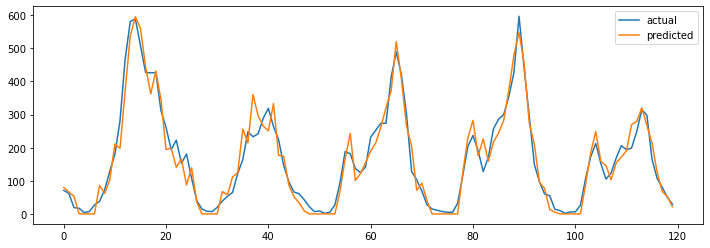

In [285]:
# Graph the holdout actual vs prediction

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(len(y_test)), y_test, label='actual')
ax.plot(np.arange(len(y_test)), yhat, label='predicted')
ax.legend();

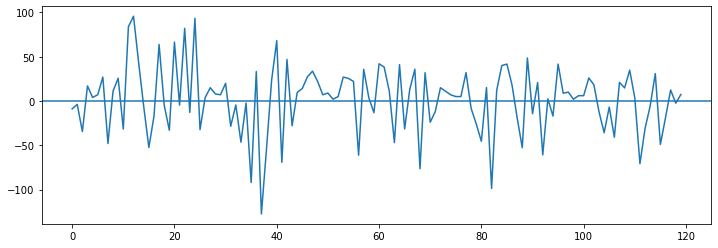

In [286]:
# residuals plot

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(len(y_test)), (y_test - yhat.reshape(len(yhat))))
ax.axhline();

In [287]:
# RMSE baseline model
ybase = np.ones(len(y_test)) * X_test[:, 0, -1].mean()

print(X_test[:, 0, -1].mean())

mean_squared_error(y_test, ybase)**0.5

139.33333333333334


148.40276464930008

In [288]:
# RMSE of this model
mean_squared_error(y_test, yhat)**0.5

37.927886279399736

uni, window(120) =  38.4, 38.6  
uni, window(120), GRU = 35.4, 37.9

In [54]:
# save model
#model.save('data/multivariate_downtown.sav')

# load model
#model = tf.keras.models.load_model('data/univariate_downtown.sav')

INFO:tensorflow:Assets written to: data/multivariate_downtown.sav/assets


## Chinatown

In [5]:
# get the stations in chinatown
groups = pd.read_csv('data/groups.csv')

chinatown_stations = set(groups[groups['group'] == 'f'].name.values)

In [6]:
# dataframe ready for EDA and/or hourly aggregation
chinatown = station_data(region=chinatown_stations)

chinatown

,date,hour,trip_time,round_trip,electric,member,trip_dist
0,2020-04-07,14,1517.0,0,0,0,4911.505672
1,2020-04-05,20,711.0,0,0,1,2636.357561
2,2020-04-23,14,2410.0,0,0,0,932.635242
3,2020-04-11,16,1457.0,0,0,0,2509.600669
4,2020-04-30,16,719.0,0,0,1,2693.995352
...,...,...,...,...,...,...,...
130633,2021-03-22,10,1268.0,0,1,1,4947.244168
130634,2021-03-12,10,1436.0,0,1,1,4985.518909
130635,2021-03-25,11,1384.0,0,1,1,4992.252039
130636,2021-03-30,11,1339.0,0,1,1,4871.430084


In [13]:
# vectorized data, should be shape 8760, 7 regardless of how many trips there were
chinatown_s = serialize(chinatown)

chinatown_s

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.08982286, 0.        , 0.        , 0.71428571, 0.17663039,
        7.        ],
       [0.07157001, 0.        , 0.        , 0.        , 0.13178059,
        3.        ],
       [0.17802923, 0.        , 0.25      , 0.25      , 0.17479441,
        4.        ]])

In [17]:
# LSTM inputs

X_train, X_test, y_train, y_test = split_and_windowize(chinatown_s, 120, 0.0001, univariate=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8400, 120, 6), (120, 120, 6), (8400,), (120,))

In [38]:
# model f for group f which is chinatown

modelf = tf.keras.Sequential()
modelf.add(tf.keras.layers.GRU(100, return_sequences=False))
modelf.add(tf.keras.layers.Dropout(0.3))
modelf.add(tf.keras.layers.Dense(1, activation='relu'))
modelf.compile(optimizer='rmsprop', loss='mse')

In [39]:
# fitting the model (takes time!)
modelf.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
525/525 [==============================] - 21s 39ms/step - loss: 225.9735
Epoch 2/50
525/525 [==============================] - 20s 39ms/step - loss: 95.6726
Epoch 3/50
525/525 [==============================] - 21s 40ms/step - loss: 75.6824
Epoch 4/50
525/525 [==============================] - 22s 42ms/step - loss: 67.0891
Epoch 5/50
525/525 [==============================] - 22s 41ms/step - loss: 64.0509
Epoch 6/50
525/525 [==============================] - 22s 41ms/step - loss: 64.8673
Epoch 7/50
525/525 [==============================] - 20s 39ms/step - loss: 62.0461
Epoch 8/50
525/525 [==============================] - 22s 41ms/step - loss: 60.5197
Epoch 9/50
525/525 [==============================] - 21s 41ms/step - loss: 59.9254
Epoch 10/50
525/525 [==============================] - 23s 43ms/step - loss: 58.2792
Epoch 11/50
525/525 [==============================] - 23s 43ms/step - loss: 58.0642
Epoch 12/50
525/525 [==============================] - 23s 44ms/step - lo

In [31]:
# to check parameters and shapes
modelf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [41]:
# make a prediction on the holdout
yhat = modelf.predict(X_test)

In [42]:
yhat.shape

(120, 1)

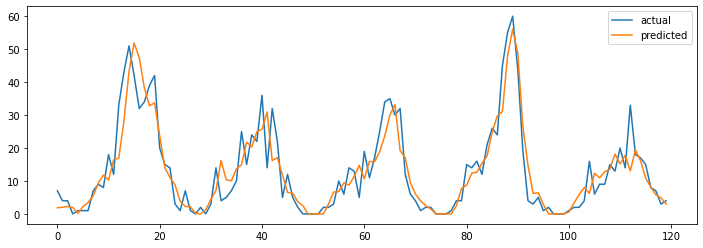

In [43]:
# Graph the holdout actual vs prediction

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(len(y_test)), y_test, label='actual')
ax.plot(np.arange(len(y_test)), yhat, label='predicted')
ax.legend();

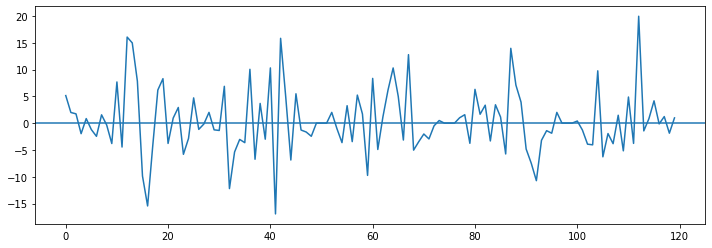

In [44]:
# residuals plot

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(len(y_test)), (y_test - yhat.reshape(len(yhat))))
ax.axhline();

In [45]:
# save model
#modelf.save('models/univariate_chinatown.sav')

# load model
#model_something = tf.keras.models.load_model('models/univariate_chinatown.sav')

In [46]:
# RMSE of this model
mean_squared_error(y_test, yhat)**0.5

6.020178372948466

In [47]:
# RMSE baseline model
ybase = np.ones(len(y_test)) * X_test[:, 0, -1].mean()

mean_squared_error(y_test, ybase)**0.5

11.55


13.799728258194072

univariate, dropout(0), window(50) = 6.3  
univariate, dropout(0.2), window(50) = 6.1  
univariate, dropout(0.3), window(120) = 6.8, 6.7, 7.6 (overfit)  
univariate, dropout(0.3), window(240) = 12 (was this done correctly?)  
multivariate, dropout(0.3), window(50) = 9.0 (8.9)  
multivariate, dropout(0.3), window(72) = 9.2, 8.1, 7.7, 9.0  
multivariate, dropout(0.3), window(120) = 8.6, 8.9  
multivariate, dropout(0.3), window(120), scaled_X = 6.9, 6.8  
multivariate, dropout(0.3), window(120), scaled_X, GRU = 6.0 (winner!)  
multivariate, dropout(0.2), window(240) = 9.2  
multivariate, dropout(0.3), window(72), extra LSTM layer = 10.9  


In [100]:
def plot_model(model, X_test, y_test):

    yhat = model.predict(X_test)

    if len(yhat) != len(y_test):
        print('shape mismatch in plotting function')

    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,7), gridspec_kw={'height_ratios': [2, 1]})

    ax1.plot(np.arange(len(y_test)), y_test, c='darkslategrey', label='actual')
    ax1.plot(np.arange(len(y_test)), yhat, c='orangered', label='predicted')
    ax1.set_ylabel('Trips in & out')
    ax1.title.set_text('Traffic predictions')
    ax1.set_xticklabels([])
    ax1.legend()

    ax2.plot(np.arange(len(y_test)), (y_test - yhat.reshape(len(yhat))), c='orangered')
    ax2.axhline(c='darkslategrey')
    ax2.set_xlabel('Hours')
    ax2.set_ylabel('Trip Error')
    ax2.title.set_text('Error between Actual and Predicted Traffic');

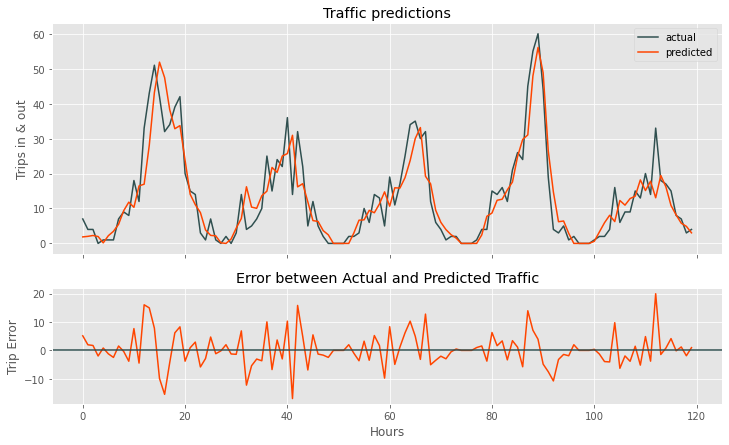

In [101]:
plot_model(modelf, X_test, y_test)

## model pipe

In [16]:
class Model:
    def __init__(self, df, univariate=True, load_model=None):
        '''output of station_data(region, eda=False) should be passed'''
        
        self.df = np.array(df)
        
        if self.df.shape[1] == 1:
            self.univariate=False
        else:
            self.univariate = univariate
        
        if self.univariate == True:
            self.X_train, self.X_test, self.y_train, self.y_test = split_and_windowize(self.df[:, -1], 120, 0.0001, univariate=self.univariate)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = split_and_windowize(self.df, 120, 0.0001, univariate=self.univariate)

        if load_model is not None:
            self.model = load_model
            return None    
        
        # Model structure, feel free to manipulate but this was the best I found
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.GRU(100, return_sequences=False))
        self.model.add(tf.keras.layers.Dropout(0.3))
        self.model.add(tf.keras.layers.Dense(1, activation='relu'))
        self.model.compile(optimizer='rmsprop', loss='mse')
    
    def windowize_data(self, data, n_prev, univariate=True):
        '''univariate'''
        n_predictions = len(data) - n_prev
        indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]

        if univariate == False:
            y = data[n_prev:, -1]
            x = data[indices]
        else:
            y = data[n_prev:]
            x = data[indices, None]
        return x, y

    def split_and_windowize(self, data, n_prev, fraction_test=0.1, univariate=True):
        '''Train/test splits data with added timestep dimension'''
        n_predictions = len(data) - 2*n_prev

        n_test  = int(fraction_test * n_predictions)
        n_train = n_predictions - n_test   

        x_train, y_train = windowize_data(data[:n_train], n_prev, univariate=univariate)
        x_test, y_test = windowize_data(data[n_train:], n_prev, univariate=univariate)
        return x_train, x_test, y_train, y_test

    def train(self):
        self.model.fit(self.X_train, self.y_train, batch_size=16, epochs=50)
    
    def predict(self, X_test=None):
        if X_test is None:
            return self.model.predict(self.X_test)
        else:
            return self.model.predict(X_test)

    def predict_plot(self, X_test=None):
        
        if X_test is None:
            X_test = self.X_test

        yhat = self.predict(X_test)

        if len(yhat) != len(self.y_test):
            print('shape mismatch in plotting function')

        fig, (ax1, ax2) = plt.subplots(2, figsize=(12,7), gridspec_kw={'height_ratios': [2, 1]})

        ax1.plot(np.arange(len(self.y_test)), self.y_test, c='darkslategrey', label='actual')
        ax1.plot(np.arange(len(self.y_test)), yhat, c='orangered', label='predicted')
        ax1.set_ylabel('Trips in & out')
        ax1.title.set_text('Traffic predictions')
        ax1.set_xticklabels([])
        ax1.legend()

        ax2.plot(np.arange(len(self.y_test)), (self.y_test - yhat.reshape(len(yhat))), c='orangered')
        ax2.axhline(c='darkslategrey')
        ax2.set_xlabel('Hours')
        ax2.set_ylabel('Trip Error')
        ax2.title.set_text('Error between Actual and Predicted Traffic');
    
    def predict_score(self, X_test=None):
        
        if X_test is None:
            X_test = self.X_test
        
        if self.univariate == True:
            ybase = np.ones(len(self.y_test)) * X_test[:, 0, -1].mean()
        else:
            ybase = np.ones(len(self.y_test)) * X_test.mean()

        ybase = mean_squared_error(self.y_test, ybase)**0.5
        
        yhat = self.predict(X_test)
        
        yhat = mean_squared_error(self.y_test, yhat)**0.5
        
        print('This model did {}% better than baseline ({})'.format(round((1-yhat/ybase)*100, 2), round(ybase, 2)))
        
        return yhat

In [73]:
dt = station_data('downtown', start_end='start')

In [74]:
model_d = Model(dt)

In [81]:
model_d.train()

Epoch 1/50
525/525 [==============================] - 23s 44ms/step - loss: 1821.7748
Epoch 2/50
525/525 [==============================] - 22s 42ms/step - loss: 1729.9207
Epoch 3/50
525/525 [==============================] - 23s 44ms/step - loss: 1855.0109
Epoch 4/50
525/525 [==============================] - 24s 46ms/step - loss: 1783.3185
Epoch 5/50
525/525 [==============================] - 24s 46ms/step - loss: 1806.1382
Epoch 6/50
525/525 [==============================] - 24s 47ms/step - loss: 1825.7476
Epoch 7/50
525/525 [==============================] - 24s 46ms/step - loss: 1816.2380
Epoch 8/50
525/525 [==============================] - 22s 43ms/step - loss: 1853.8666
Epoch 9/50
525/525 [==============================] - 24s 45ms/step - loss: 1803.2239
Epoch 10/50
525/525 [==============================] - 25s 47ms/step - loss: 1837.5951
Epoch 11/50
525/525 [==============================] - 24s 45ms/step - loss: 1777.6862
Epoch 12/50
525/525 [==============================]

In [85]:
model_d.predict_score()

This model did 69.35% better than baseline (111.94)


34.31374887420373

china start: 4.8, 5.3 (9.6)  
china end: 6.7, 6.5, 7.13 ()  
uptown start: 8.5, 8.5 (20.8)  
uptown end: 11.3, 10.6, 11.8 (31.9)  
hyde start: 5.2, 5.2 (11.2)  
hyde end: 5.6, 5.7 (13.5)  
wicker start: 10.7, 10.5 (28.1)  
wicker end: 13.8, 15.2 (47.2)  
lincoln start: 16.5, 19.7 (53.2)  
lincoln end: 27.6, 25.5, 29.4 (85.1)  
downtown start: 32.9, 28.6, 34.3 (111.9)  
downtown end: 39.2, 43.4, 38.1, 48.8 (147.1)  

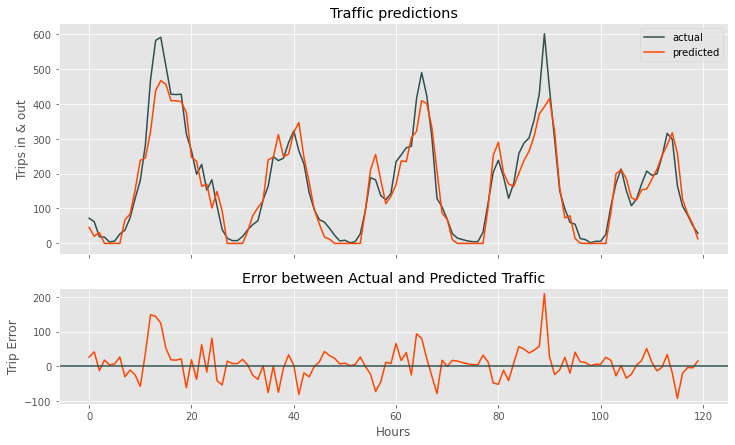

In [69]:
model_d.predict_plot()

In [80]:
# save model (saves as a directory)
#model_l.model.save('models/downtown_start')

# load model
#model = tf.keras.models.load_model('data/univariate_downtown.sav')

INFO:tensorflow:Assets written to: models/downtown_start/assets


#### how to load models back into class Model

In [11]:
old_model = tf.keras.models.load_model('models/hydepark_end')

In [12]:
old_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hp_e = station_data('hyde_park', start_end='end')

In [17]:
loaded_model = Model(df=hp_e, load_model=old_model)

In [19]:
loaded_model.predict_score()

This model did 57.54% better than baseline (13.54)


5.749883306626169

In [ ]:
loaded_model.train()

## by the book
https://www.tensorflow.org/tutorials/structured_data/time_series

In [82]:
# get a set of data


In [83]:
# train, validate, test split it


In [84]:
# normalize each split independently


The right window includes
- input width: how many datapoints of history are you looking at
- offset: how many timesteps into the future are you trying to predict (eg not target in the next hour, but target at 12 hrs from now)
- label width: how many timesteps are you predicting (predict one vs predict many)

In [ ]:
# investigate WindowGenerator and tf.data.Dataset
